In [1]:
import pandas as pd 
from PIL import Image 
import os
from pathlib import Path 
import matplotlib.pyplot as plt 
import numpy as np
import re
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [2]:
DATA_DIR = Path('../data/')
IMG_DIR = DATA_DIR/'images'

In [3]:
df = pd.read_csv('../data/image_labels.csv')
df.head(2)

,image,label,left,width,top,height
0,57503_000116_Endzone_frame443.jpg,Helmet,1099,16,456,15
1,57503_000116_Endzone_frame443.jpg,Helmet,1117,15,478,16


In [4]:
trn_helmets_preds = pd.read_csv('../data/train_baseline_helmets.csv')
trn_helmets_preds.head(2)

,video_frame,left,width,top,height,conf
0,57778_004244_Endzone_1,598,18,278,18,0.080017
1,57778_004244_Endzone_1,856,16,294,22,0.089050


In [5]:
images = list(IMG_DIR.rglob('*.jpg'))
len(images), images[:3]

(9947,
 [PosixPath('../data/images/57947_003626_Sideline_frame391.jpg'),
  PosixPath('../data/images/57767_003038_Sideline_frame0627.jpg'),
  PosixPath('../data/images/57502_004089_Sideline_frame0803.jpg')])

In [6]:
def plot_boxes(
    image_path, 
    boxes,
    linewidth=0.5,
    edgecolor="r",
    facecolor="none",
    ax = None, 
    grid = False,
    base = 100
):
    if ax is None: ax = plt.subplots()[1]
    ax.imshow(Image.open(image_path))
    ax.set_title(image_path.name)
    for box in boxes:
        x, y, w, h = box
        ax.add_patch(
            Rectangle((x, y), w, h, linewidth=linewidth, 
                      edgecolor=edgecolor, facecolor=facecolor))
    if grid: 
        ax.xaxis.set_major_locator(MultipleLocator(base))
        ax.yaxis.set_major_locator(MultipleLocator(base))
        ax.grid(which='major', color='#CCCCCC', linestyle='--', alpha=0.35)
        ax.grid(which='minor', color='#CCCCCC', linestyle=':', alpha=0.35)
    return ax

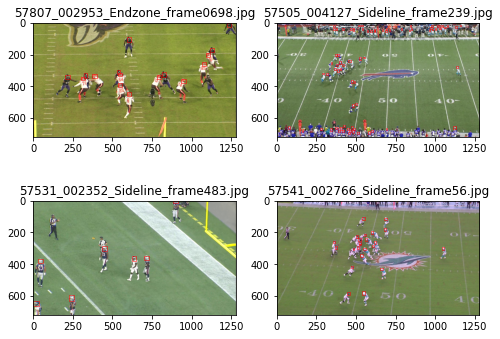

In [7]:
num_imgs    = 4 # ideally a square num, like `4,9,16..`
box_coords  = ['left', 'top', 'width', 'height'] # x,y,w,h
image_paths = np.random.choice(images, num_imgs) # random image paths

# rows, cols for plot
rows = int(np.sqrt(num_imgs)); cols = num_imgs // rows
axs = np.array(plt.subplots(rows, cols, figsize=(4*rows, 3*cols))[1]).flatten()

for ax, image_path in zip(axs, image_paths):
    boxes = df.query(f"image=='{image_path.name}'")[box_coords].values
    plot_boxes(image_path=image_path, boxes=boxes, ax=ax)

## Display Video

In [8]:
debug=False

In [9]:
from IPython.display import Video, display

if debug:
    video_path = '../data/train/58106_002918_Endzone.mp4'
    display(Video(data=video_path, embed=True, width=256, height=256))

## Train labels

All videos have already been converted to images by `frame_id` based on `extract_frames_from_video.py`. These images are stored at `../data/usr/video_frames/`.

In [10]:
video_frame_imgs = list(Path('../data/usr/video_frames/').rglob('*.png'))
len(video_frame_imgs)

52141

In [11]:
train_labels = pd.read_csv('../data/train_labels.csv')

In [12]:
assert train_labels.video_frame.nunique()-1 == len(video_frame_imgs)

In [13]:
frame_pat = re.compile(r'(.*)_(\d+)')

def extract_video_frame(o): return frame_pat.findall(o)
def get_video_frame_path(o, dir='../data/usr/video_frames'): 
    name, frame_id = extract_video_frame(o)[0]
    fname = f"{name}_{str(frame_id).zfill(5)}.png"
    return f'{dir}/{name}/{fname}'

In [14]:
img_path = get_video_frame_path(train_labels.video_frame[0])
boxes = train_labels.query(f"video_frame=='{train_labels.video_frame[0]}'")[['left', 'top', 'width', 'height']].values
img_path

'../data/usr/video_frames/57583_000082_Endzone/57583_000082_Endzone_00001.png'

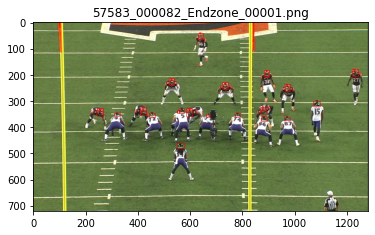

In [15]:
plot_boxes(Path(img_path), boxes);

## Helmets

In [16]:
trn_helmet_preds = pd.read_csv('../data/train_baseline_helmets.csv')
trn_helmet_preds['gameKey'] = trn_helmet_preds.video_frame.map(lambda o: int(o.split('_')[0]))
trn_helmet_preds['playID'] = trn_helmet_preds.video_frame.map(lambda o: int(o.split('_')[1]))
trn_helmet_preds.head(2)

,video_frame,left,width,top,height,conf,gameKey,playID
0,57778_004244_Endzone_1,598,18,278,18,0.080017,57778,4244
1,57778_004244_Endzone_1,856,16,294,22,0.089050,57778,4244


In [17]:
# get image path based on `video_frame`
img_path = get_video_frame_path(trn_helmet_preds.video_frame[0])
img_path

'../data/usr/video_frames/57778_004244_Endzone/57778_004244_Endzone_00001.png'

In [18]:
# helmet bounding box predictions for `video_frame`
boxes = trn_helmet_preds.query(f"video_frame=='{trn_helmet_preds.video_frame[0]}'")[['left', 'top', 'width', 'height']].values
boxes.shape

(18, 4)

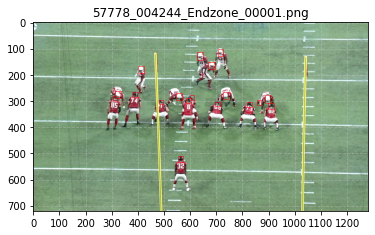

In [19]:
# plot image and box predictions from baseline train
plot_boxes(Path(img_path), boxes, grid=True);

## Position Data

In [20]:
trn_player_track_data = pd.read_csv('../data/train_player_tracking.csv', dtype={'gameKey': int, 'playID': int})
trn_player_track_data.head(2)

,gameKey,playID,player,time,x,y,s,a,dis,o,dir,event
0,57583,82,H97,2018-09-14T00:23:45.500Z,38.89,28.06,0.0,0.0,0.0,261.28,222.79,NaN
1,57583,82,H97,2018-09-14T00:23:45.599Z,38.89,28.06,0.0,0.0,0.0,261.28,221.93,NaN


In [21]:
def add_track_features(player_track_data, fps=59.94, snap_frame=10):
    """
    Add estimated frameID `est_frame` to tracking data.
    """
    player_track_data = player_track_data.copy()
    player_track_data["game_play"] = (
        player_track_data["gameKey"].astype("str") + "_" + player_track_data["playID"].astype("str").str.zfill(6))
    player_track_data["time"] = pd.to_datetime(player_track_data["time"])
    
    # group by `gameKey_playID` 
    snap_dict = player_track_data.query('event == "ball_snap"').groupby("game_play")["time"].first().to_dict()
    player_track_data["snap"] = player_track_data["game_play"].map(snap_dict)
    player_track_data["isSnap"] = player_track_data["snap"] == player_track_data["time"]
    player_track_data["team"] = player_track_data["player"].str[0].replace("H", "Home").replace("V", "Away")
    
    # get time from `snap` in seconds as `snap_offset`
    player_track_data["snap_offset"] = (player_track_data["time"] - player_track_data["snap"]).astype(
        "timedelta64[ms]"
    ) / 1_000
    
    # total number of frames since `snap` + frame at which `snap` occured, ie., 10th frame
    player_track_data["est_frame"] = (
        ((player_track_data["snap_offset"] * fps) + snap_frame).round().astype("int"))
    return player_track_data

In [22]:
trn_player_track_data = add_track_features(trn_player_track_data)
trn_player_track_data.head(2)

,gameKey,playID,player,time,x,y,s,a,dis,o,dir,event,game_play,snap,isSnap,team,snap_offset,est_frame
0,57583,82,H97,2018-09-14 00:23:45.500000+00:00,38.89,28.06,0.0,0.0,0.0,261.28,222.79,NaN,57583_000082,2018-09-14 00:24:00.200000+00:00,False,Home,-14.700,-871
1,57583,82,H97,2018-09-14 00:23:45.599000+00:00,38.89,28.06,0.0,0.0,0.0,261.28,221.93,NaN,57583_000082,2018-09-14 00:24:00.200000+00:00,False,Home,-14.601,-865


### Range of values for tracking data and helmet predictions

Because each image size is `1280 x 720`. So bounding boxes are in this range. Similarly, `X` and `y` are 0-120 and 0-53.3 yards.

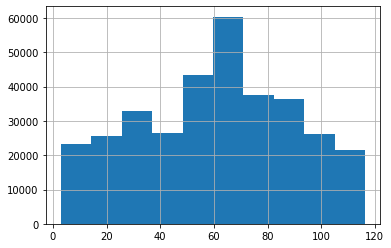

In [23]:
# `X` between 0-120 (Football field size)
trn_player_track_data.x.hist();

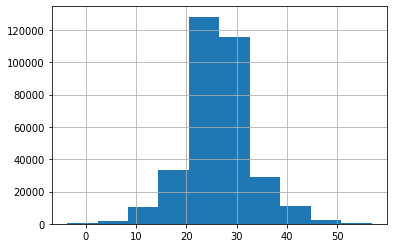

In [24]:
# `y` between 0-53.3 (Football field size)
trn_player_track_data.y.hist();

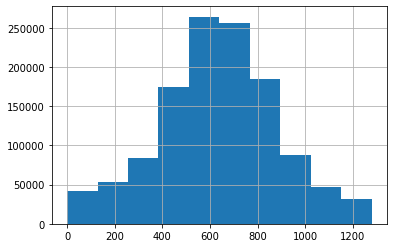

In [25]:
trn_helmet_preds.left.hist();

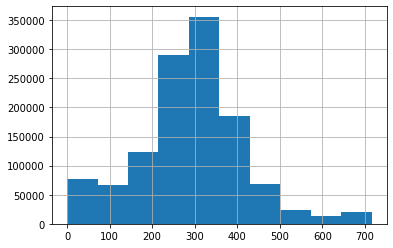

In [26]:
trn_helmet_preds.top.hist();

## Example `game_play`

In [27]:
# add bounding box centers
trn_helmet_preds['x_center'] = trn_helmet_preds.left + (trn_helmet_preds.width/2)
trn_helmet_preds['y_center'] = trn_helmet_preds.top + (trn_helmet_preds.height/2)
trn_helmet_preds.head(2)

,video_frame,left,width,top,height,conf,gameKey,playID,x_center,y_center
0,57778_004244_Endzone_1,598,18,278,18,0.080017,57778,4244,607.0,287.0
1,57778_004244_Endzone_1,856,16,294,22,0.089050,57778,4244,864.0,305.0


In [28]:
EXAMPLE_PLAY = np.random.choice(trn_player_track_data.query("est_frame==10").game_play.unique(), 1)[0]
EXAMPLE_PLAY

'57785_002026'

In [29]:
example_helmet_preds_endview = trn_helmet_preds.query(f"video_frame=='{EXAMPLE_PLAY}_Endzone_10'").copy()

# convert to `int` 
_gameKey, _playID, view, _frame = example_helmet_preds_endview.video_frame.iloc[0].split('_')
_gameKey = int(_gameKey)
_playID = int(_playID)
_frame = int(_frame)

example_helmet_preds_endview.shape, _frame, _gameKey, _playID, view

((20, 10), 10, 57785, 2026, 'Endzone')

### Football Field (Player locs)

In [30]:
import matplotlib.patches as patches
import matplotlib.pylab as plt

In [31]:
def create_football_field(
    linenumbers=True,
    endzones=True,
    highlight_line=False,
    highlight_line_number=50,
    highlighted_name="Line of Scrimmage",
    fifty_is_los=False,
    figsize=(12, 6.33),
    field_color="lightgreen",
    ez_color='forestgreen',
    ax=None,
):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle(
        (0, 0),
        120,
        53.3,
        linewidth=0.1,
        edgecolor="r",
        facecolor=field_color,
        zorder=0,
    )

    if ax is None:
        fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='black')

    if fifty_is_los:
        ax.plot([60, 60], [0, 53.3], color="gold")
        ax.text(62, 50, "<- Player Yardline at Snap", color="gold")
    # Endzones
    if endzones:
        ez1 = patches.Rectangle(
            (0, 0),
            10,
            53.3,
            linewidth=0.1,
            edgecolor="black",
            facecolor=ez_color,
            alpha=0.6,
            zorder=0,
        )
        ez2 = patches.Rectangle(
            (110, 0),
            120,
            53.3,
            linewidth=0.1,
            edgecolor="black",
            facecolor=ez_color,
            alpha=0.6,
            zorder=0,
        )
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    ax.axis("off")
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            ax.text(
                x,
                5,
                str(numb - 10),
                horizontalalignment="center",
                fontsize=20,  # fontname='Arial',
                color="black",
            )
            ax.text(
                x - 0.95,
                53.3 - 5,
                str(numb - 10),
                horizontalalignment="center",
                fontsize=20,  # fontname='Arial',
                color="black",
                rotation=180,
            )
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color="black")
        ax.plot([x, x], [53.0, 52.5], color="black")
        ax.plot([x, x], [22.91, 23.57], color="black")
        ax.plot([x, x], [29.73, 30.39], color="black")

    if highlight_line:
        hl = highlight_line_number + 10
        ax.plot([hl, hl], [0, 53.3], color="yellow")
        ax.text(hl + 2, 50, "<- {}".format(highlighted_name), color="yellow")

    border = patches.Rectangle(
        (-5, -5),
        120 + 10,
        53.3 + 10,
        linewidth=0.1,
        edgecolor="orange",
        facecolor="white",
        alpha=0,
        zorder=0,
    )
    ax.add_patch(border)
    ax.set_xlim((0, 120))
    ax.set_ylim((0, 53.3))
    return ax

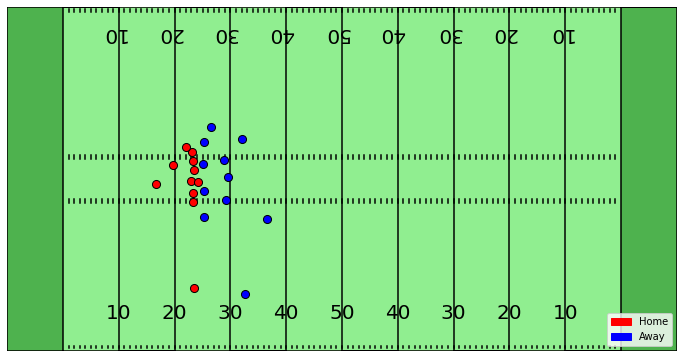

In [32]:
example_player_locs = trn_player_track_data.query("game_play == @EXAMPLE_PLAY and isSnap == True")
ax = create_football_field()
colors = {'Away' :'blue','Home':'red'}

for team, d in example_player_locs.groupby("team"):
    ax.scatter(d["x"], d["y"], color=colors[team], s=65, lw=1, edgecolors="black", zorder=5)

home = mpatches.Patch(color='red', label='Home')
away = mpatches.Patch(color='blue', label='Away')

plt.legend(handles=[home, away], loc='lower right');

###  Helmet centers Sideline

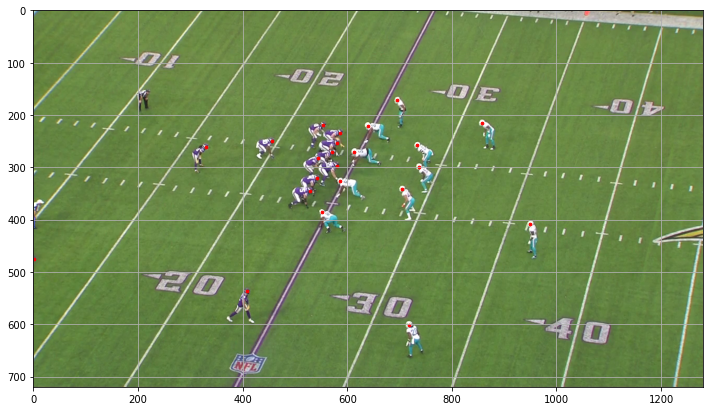

In [33]:
# plot helmet centers SIDELINE
fig,ax = plt.subplots(figsize=(12,8))
example_helmet_preds_sideline = trn_helmet_preds.query(f"video_frame=='{EXAMPLE_PLAY}_Sideline_{_frame}'").copy()
ax.imshow(Image.open(get_video_frame_path(o=f'{EXAMPLE_PLAY}_Sideline_{_frame}')))
ax.scatter(x=example_helmet_preds_sideline.x_center, y=example_helmet_preds_sideline.y_center, c='red', s=7)
ax.grid();

###  Helmet centers ENDVIEW

In [34]:
f"{EXAMPLE_PLAY}_Endzone"

'57785_002026_Endzone'

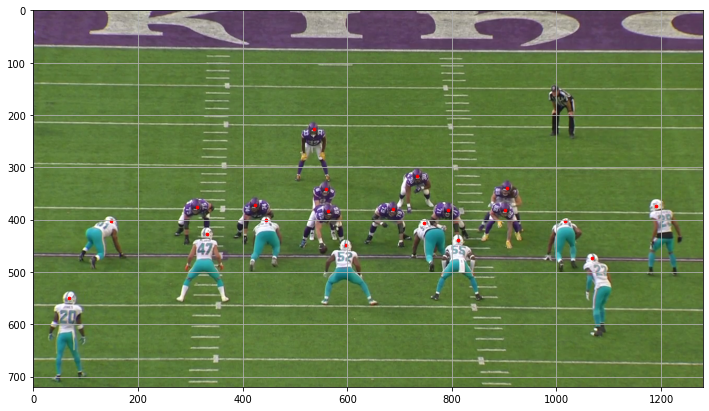

In [35]:
# plot helmet centers ENDVIEW
fig,ax = plt.subplots(figsize=(12,8))
ax.imshow(Image.open(get_video_frame_path(o=f'{EXAMPLE_PLAY}_Endzone_{_frame}')))
ax.scatter(x=example_helmet_preds_endview.x_center, y=example_helmet_preds_endview.y_center, c='red', s=7)
ax.grid();

In [36]:
# So the main question is - how do I use this data to match the box coordinates on the image above?
example_player_locs[['player', 'x', 'y', 's', 'a', 'dis', 'o', 'dir']]

,player,x,y,s,a,dis,o,dir
138958,H82,33.16,30.79,0.00,0.00,0.06,142.63,13.14
139101,H79,33.44,27.97,0.02,0.31,0.01,47.23,77.89
139244,H8,32.92,26.28,0.00,0.00,0.01,50.34,256.87
139387,H71,33.31,29.39,0.11,0.64,0.02,93.50,144.87
139530,H74,33.24,24.47,0.06,0.56,0.02,49.48,39.05
139673,H19,33.50,9.79,0.00,0.01,0.01,101.15,227.86
139816,H89,31.96,31.55,1.52,3.69,0.13,119.05,161.15
139959,H30,29.78,28.77,0.00,0.00,0.00,79.21,97.85
140102,H33,26.63,25.90,0.00,0.00,0.02,166.51,140.77
140245,H65,34.14,26.15,0.13,0.31,0.02,30.34,142.20


In [37]:
example_helmet_preds_endview[['x_center', 'y_center']]

,x_center,y_center
490028,1017.0,402.5
490029,444.0,401.0
490030,149.0,403.0
490031,1068.0,474.0
490032,747.0,406.5
490033,563.5,383.5
490034,905.0,340.0
490035,559.0,341.0
490036,902.0,381.0
490037,734.0,316.5
